In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.io import ascii
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

In [3]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    ap.plot(color='blue', lw=.5, alpha=.5)
    an.plot(color='red', lw=.5, alpha=.5)
    plt.colorbar()
    plt.grid(True)
    plt.gcf().set_size_inches(10, 6)
    plt.show()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def ap_phot(data, ap, an, method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
    
    elif method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
    else:
        print('\n\nPlease give a valid method kthx\n\n')
        
    table['apparent_mag'] = float('NaN')
    for i in range(len(table)):
        if table['star_bkgsub'][i] >= 0:
            table['apparent_mag'][i] = zmag - 2.5 * math.log10(aperture_correction * table['star_bkgsub'][i] / conv)
    
    return table

data/PAL5\PAL5__e1\PAL5__e1_4p5um.fits
EXPTIME: 81.4431
FLUXCONV: 0.1447
Mean: 43.50629425048828
Median: 42.777061462402344
Std dev: 12.042956352233887


No. of stars detected: 677


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


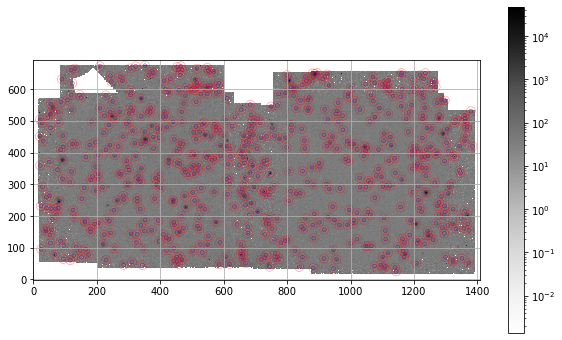

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1144.5399 24.854201 ...      4724.9136         nan          nan
  2 946.21939 34.580988 ...      4627.5053   251.37089    19.072132
  3  882.2909 36.005182 ...      4850.1437   1972.8833    16.835166
  4  1106.997 36.662134 ...      5130.0633   1500.6513     17.13222
  5 1140.4175 37.684209 ...      4681.0551   1294.3212    17.292814
  6 744.48467 39.806977 ...      7513.6902         nan          nan
  7 838.19246 39.184168 ...      5406.8002         nan          nan
  8 1109.6827 41.697305 ...      4961.2027   1393.4898     17.21266
  9 1075.5198 42.180766 ...      4485.5734   835.50484    17.768047
 10 343.85128  44.83127 ...      5196.4756  -1538.7792          nan
...       ...       ... ...            ...         ...          ...
668 468.52448 660.46381 ...       4867.467  -185

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


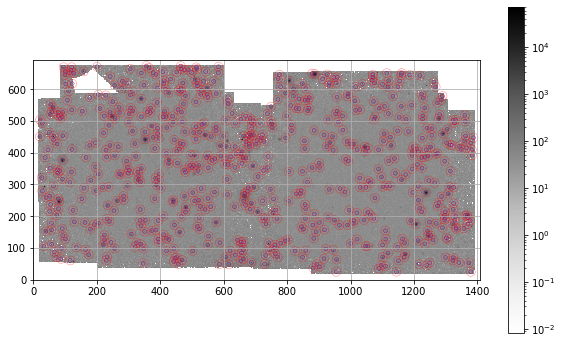

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 954.85966  24.23746 ...      4845.9484         nan          nan
  2 1144.9457 24.567983 ...      4428.3446         nan          nan
  3 1379.5331 24.015838 ...      4813.1792         nan          nan
  4 1088.8955 34.676884 ...      5188.6755   904.48736    17.682048
  5 882.51748 35.908934 ...      5045.8592     1288.23     17.29807
  6 902.43913 40.292259 ...      5013.4183   1424.0602    17.189233
  7 1110.1888 41.720154 ...      4757.3262   1719.9507    16.984264
  8 1096.2309 45.084921 ...      5200.2271   1659.8176    17.022903
  9 1240.3962 44.671493 ...      4503.6075  -27.446829          nan
 10 586.34316 47.972803 ...      6022.4737   956.54855    17.621286
...       ...       ... ...            ...         ...          ...
674 465.46104 664.17748 ...      5122.5098  -483

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


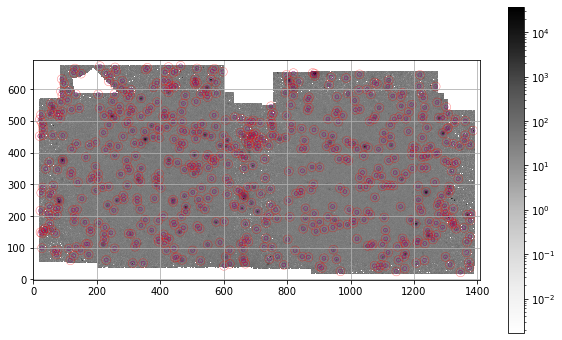

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1346.7509 22.447788 ...      4593.4455         nan          nan
  2 1144.4618 25.286524 ...      4386.2407   2158.7993    16.737554
  3 968.28399 25.690913 ...      4471.3761   1727.8064    16.979347
  4 1170.7755 34.117737 ...      4570.9743  -400.82737          nan
  5 909.29517 36.193983 ...      4589.7086     942.327    17.637581
  6 1088.1938 35.785014 ...      4945.0967   888.55192    17.701378
  7 1375.6315 37.172736 ...      4947.4118  -1961.7521          nan
  8 902.67012 41.469862 ...      4901.7921   771.77793    17.854354
  9 601.06955  42.76362 ...      7861.0401         nan          nan
 10 1075.8361 42.961239 ...      4685.3219    188.1712    19.386702
...       ...       ... ...            ...         ...          ...
651 563.93766 656.82611 ...      4581.3958   377

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


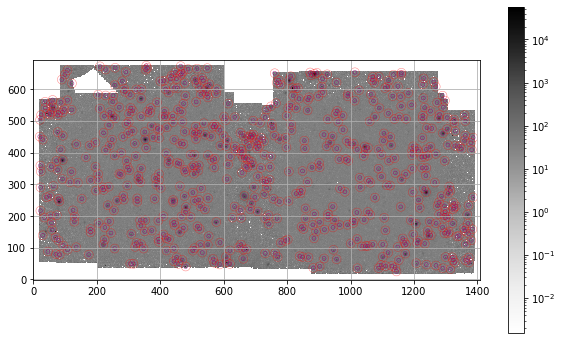

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1144.9417 25.195736 ...      4370.0827         nan          nan
  2 1314.7389 32.381279 ...      4729.9614  -551.25785          nan
  3 1290.6808 35.201137 ...      4166.4398   983.95689    17.590682
  4  882.4964 36.357056 ...      4616.4979   1788.8267    16.941701
  5 1021.9917 35.321941 ...      4670.7033   482.31591    18.364793
  6 1088.5127 35.668281 ...      5074.2761    1166.838    17.405596
  7   1140.79 37.962458 ...      4245.2692   1628.3109    17.043779
  8 902.73793 41.317256 ...       4800.444   1060.5653    17.509278
  9 480.05272 40.729618 ...      4880.1575         nan          nan
 10 1110.4698 42.242767 ...      4639.2135   1711.2595    16.989832
...       ...       ... ...            ...         ...          ...
663 227.35558 661.93265 ...      4060.9346   492

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


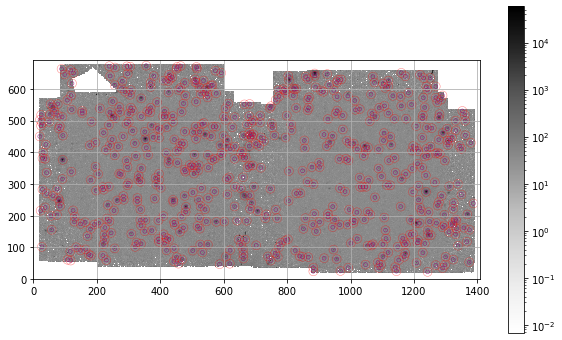

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1242.9788 22.789431 ...      3918.8392         nan          nan
  2 882.58449 24.670778 ...      5455.2444  -140.63518          nan
  3 1144.7818 25.000635 ...      4284.9046         nan          nan
  4 968.19393 25.704694 ...      5159.4283   1476.7972    17.149824
  5 992.79964 35.979427 ...      4705.1488   56.335882    20.696163
  6 1089.0207 35.271465 ...      5226.4178   570.41199    18.182654
  7 1290.4825 34.909901 ...      4083.0376   1153.3872    17.418188
  8  882.6489 36.144941 ...      4958.0194   1646.8683    17.031479
  9 1141.1626 37.892305 ...      4452.2373   1175.4603    17.397606
 10 1268.9094 43.938903 ...      4328.3453   905.32141    17.681119
...       ...       ... ...            ...         ...          ...
638 451.08471 663.77117 ...      4571.8355   361

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


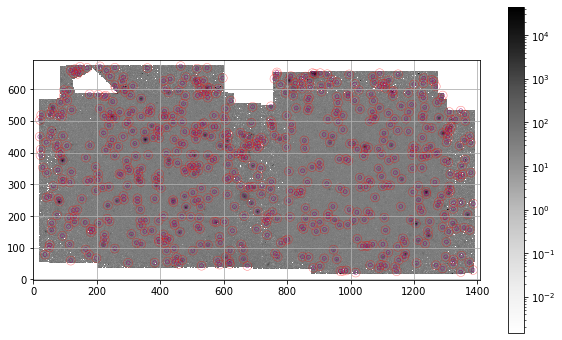

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1016.3233 21.630295 ...      3823.1905         nan          nan
  2 1347.7233 23.238973 ...      4109.3484         nan          nan
  3  968.1378 26.062758 ...      4337.9065   41594.602     13.52559
  4  1145.256 25.875263 ...      3901.7142   1933.3052    16.857431
  5 976.21854 26.868677 ...      4669.5514         nan          nan
  6 986.34408 28.193018 ...      4446.0294         nan          nan
  7 1386.2377 29.735111 ...      4643.2849         nan          nan
  8 1089.8918 35.604196 ...      5009.5423    991.4717    17.582481
  9 1290.1955 34.961616 ...      4189.8847   481.71524    18.366206
 10 882.55064 36.637414 ...      4766.4351     1056.86    17.513138
...       ...       ... ...            ...         ...          ...
649  230.0436 658.72808 ...      4630.0479   878

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


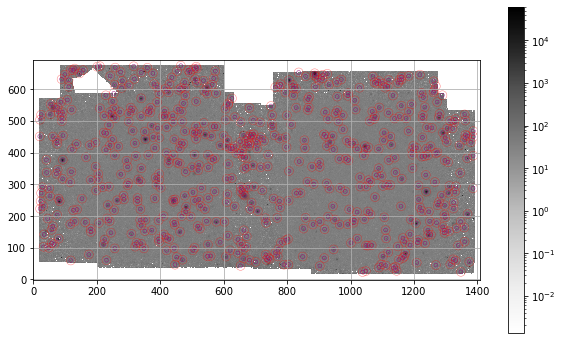

WARNING

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1038.0353 23.301006 ...      4850.1773         nan          nan
  2 1348.1454 23.918322 ...      4793.2209         nan          nan
  3 1048.3954 26.532582 ...      4415.8641   214.34784    19.245408
  4 1145.4016 26.975264 ...      4849.8412   1650.4269    17.029215
  5 1135.2322 36.313501 ...      4549.1779  -241.62062          nan
  6 1089.3884 37.428482 ...      5334.2594   467.92597    18.397763
  7 1141.7016 39.912601 ...      4455.5468   955.65519    17.622453
  8 903.01773 42.514571 ...      4981.0514   881.22181    17.710493
  9 653.14029 42.687296 ...      7104.5028         nan          nan
 10 1110.9819 43.888546 ...      4465.5526   1542.6644    17.102527
...       ...       ... ...            ...         ...          ...
643 504.12516 663.66012 ...       5360.955  -108

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


No. of stars detected: 690


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


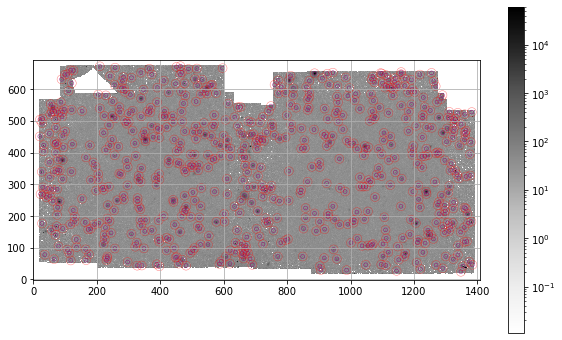

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1348.0835 24.070732 ...      4873.0454         nan          nan
  2 1145.2521 26.879144 ...      4459.8721    1815.457    16.925773
  3  987.7626 29.254764 ...      4824.0638         nan          nan
  4 906.38292 29.774328 ...      4748.1682  -1333.7565          nan
  5 1220.2954 32.911364 ...       4071.898  -171.09145          nan
  6 1290.5761 35.072759 ...      4082.1736   793.01269    17.825038
  7   396.831 41.316354 ...      4720.0988         nan          nan
  8 903.02706 41.971359 ...      5183.6612   640.16468    18.057509
  9 1354.6296 41.709971 ...      4335.1087    226016.1    11.687889
 10 327.23383 43.347804 ...      4923.7026         nan          nan
...       ...       ... ...            ...         ...          ...
681 126.10082 659.07851 ...      5499.7014   187

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


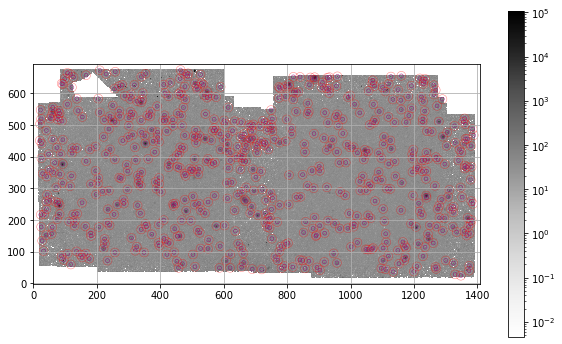

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1347.9959 24.320312 ...       4454.045         nan          nan
  2 1330.1098 28.551847 ...      4750.0264  -70.243778          nan
  3 1134.5095 36.530439 ...      4492.2953  -478.32672          nan
  4 1199.4287 37.220634 ...       3878.471   565.78959    18.191674
  5 1373.8517 40.114213 ...      4939.9143  -129.06165          nan
  6 903.61551 41.924677 ...      5002.1415   889.78458    17.700099
  7 719.70346 44.124864 ...      6249.3448   132.42517    19.768385
  8 689.86169 45.034477 ...      7474.6197         nan          nan
  9  1111.248  44.42033 ...      4663.7387   1487.4253    17.142223
 10 1269.8519 45.759291 ...      4481.6206  -38.285592          nan
...       ...       ... ...            ...         ...          ...
668 526.76981 658.76632 ...      4401.6346  -876

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


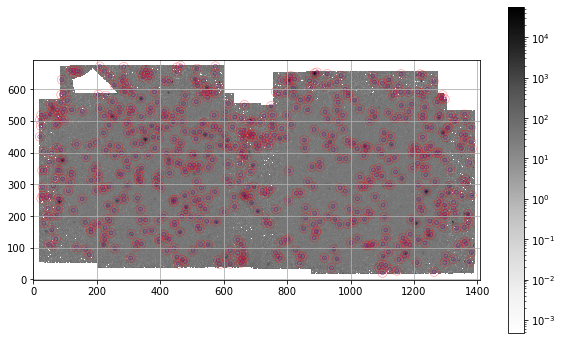

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1100.8614 20.300254 ...      4722.0459         nan          nan
  2 1263.9133 23.587634 ...      4147.0731         nan          nan
  3 1145.7866  27.32101 ...      4391.0684   2043.2841    16.797388
  4 1124.7628 31.532049 ...      4400.7014   6909.5767    15.474581
  5 939.82415 36.280806 ...       4275.142   620.49332    18.091367
  6 1089.9508 37.257825 ...      4653.5655   1168.1907    17.404426
  7 1111.3447 43.864121 ...      4585.4648   1031.5298    17.539506
  8 586.45357 48.146244 ...      5925.6599   843.45276    17.758058
  9 1097.5076 47.560199 ...      4879.2871   1619.5566     17.04972
 10 457.64847 49.244246 ...         4780.3   879.06268     17.71316
...       ...       ... ...            ...         ...          ...
662  139.8359 657.46123 ...      5923.9639  -725

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


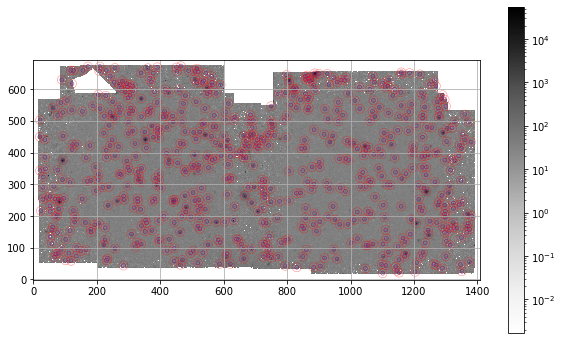

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1101.5058 19.582608 ...      4767.4545         nan          nan
  2 1153.0051 21.339225 ...      4292.9564         nan          nan
  3 1203.6237 23.704711 ...      4306.8783         nan          nan
  4 1351.5254 25.424118 ...      4518.5816         nan          nan
  5  1146.115 27.080223 ...      4267.4148   1499.0739    17.133566
  6 1046.4975 34.515355 ...       4459.651   318.43931    18.815557
  7 1289.7418 34.907344 ...      3975.6047   718.16903    17.932557
  8 830.52413 38.093838 ...      4804.3422         nan          nan
  9 883.68652 37.773671 ...      4685.4401   1456.1457    17.165111
 10 1142.5859 40.264872 ...      4085.7448   1757.1626    16.961093
...       ...       ... ...            ...         ...          ...
665 156.37547 659.08157 ...      5135.8971     5

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


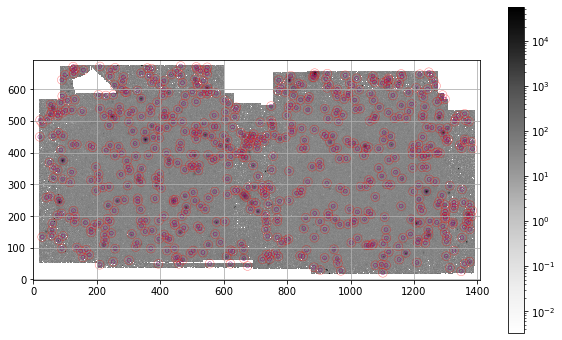

 id  xcenter   ycenter  ... bkg_sum_median star_bkgsub apparent_mag
       pix       pix    ...                                        
--- --------- --------- ... -------------- ----------- ------------
  1 1102.0242 21.014391 ...      4416.9433         nan          nan
  2 1348.8529 25.704786 ...       4441.439         nan          nan
  3 969.58943 27.080542 ...      4741.2153   1290.3698    17.296631
  4 904.39341 29.638541 ...      4367.5554  -348.50681          nan
  5 1313.5771 36.496643 ...      4222.6259  -337.31918          nan
  6 884.28397 38.289893 ...      4806.6825   728.47619    17.917378
  7 675.09838 42.438403 ...      7195.1285         nan          nan
  8 1078.6033 44.605206 ...       4198.956   649.77847    18.041503
  9  1112.087 44.615426 ...      4414.3541    1240.195    17.339692
 10 208.55447 46.328467 ...      4501.3537   828.72353    17.777392
...       ...       ... ...            ...         ...          ...
654 130.25124 663.55314 ...      5064.3808   333

In [5]:
base_dir = 'data/PAL5/*/'
#channel = '3p6um'
channel = '4p5um'

sigma_level = 6.
sigma_level_PSF = 20.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5

if channel == '3p6um':
    zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
    aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
elif channel == '4p5um':
    zmag = 18.32
    aperture_correction = 1.120
else:
    print('Please select a valid channel')

for filename in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    
    ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###
    
    with fits.open(filename) as hdu_list:        
        print(filename)
        image_data = hdu_list[0].data
        hdr = hdu_list[0].header
        exptime = hdr['EXPTIME']
        fluxconv = hdr['FLUXCONV']
        conv = exptime / fluxconv
        print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
        data = image_data * conv
        
    mean, median, std = sigma_clipped_stats(data, sigma=4.)
    print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))
    
    ###   LOCATING STARS AND PLOTTING THEM   ###
    # could maybe put most of this in its own starfind function? including aperture and position bits

    daofind = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness)
    sources = daofind(data - median)
    pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(pos, r_ap)
    annuli = CircularAnnulus(pos, r_in, r_out)
    print('No. of stars detected: {0}'.format(len(sources)))
    plotting(data, apertures, annuli, 'Greys')
    
    ###   DOING APERTURE PHOTOMETRY   ###
    
    phot_table = ap_phot(data, apertures, annuli, 'median')
    print_table_nicely(phot_table)